# Real or Fake Job Posting Analysis and Prediction

 
The dataset contains 18 columns:
 - **job_id**: _Unique Job ID._
 - **title**: _The title of the job ad entry._
 - **location**: _Geographical location of the job ad._
 - **department**: _Corporate department (e.g. sales)._
 - **salary_range**: _Indicative salary range (e.g. 50.000-60.000)._
 - **company_profile**: _A brief company description._
 - **description**: _The details description of the job ad._
 - **requirements**: _Enlisted requirements for the job opening._
 - **benefits**: _Enlisted offered benefits by the employer._
 - **telecommuting**: _True for telecommuting positions._
 - **has_company_logo**: _True if company logo is present._
 - **has_questions**: _True if screening questions are present._
 - **employment_type**: _Full-time, Part-time, Contract, etc._
 - **required_experience**: _Executive, Entry, Intern, etc._
 - **required_education**: _Doctorate, Master's Degree, Bachelor, etc._
 - **industry**: _Automotive, IT, Health Care, etc._
 - **function**: _Consulting, Engineering, Research, etc._
 - **fraudulent**: _Target. 1 if fake, 0 if real._
 
The questions I am going to answer are:

    1. Is there a better feature to predict if a job post is fake?
    2. Is there a different text length pattern for fraudulent job posts or non-fraudulent ones?
    3. How important is the company profile in real job posts?
    
#### Below is the sequence I will be following:
    1. Reading and Understanding the Data
    2. Exploratory analysis
         -> Missing data
         -> Data types in the dataframe
         -> Visualization to check for patters and insights
    3. Machine Learning Model
        
## Important note
 > **This notebook is intended exclusively to practicing and learning purposes. Any corrections, comments and suggestions are more than welcome and I would really appreciate it. Feel free to get in touch if you liked it or if you want to colaborate somehow.**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/real-or-fake-fake-jobposting-prediction/fake_job_postings.csv


# 1. Reading and Understanding the Data

In [2]:
# Imports for Exploratory Data Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Imports for Machine Learning Models
import string
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# Validation
from sklearn.metrics import classification_report, confusion_matrix

# Set the style of the plots' background
sns.set_style("darkgrid")

# Show the plot in the same window as the notebook
%matplotlib inline

In [3]:
jobs = pd.read_csv("/kaggle/input/real-or-fake-fake-jobposting-prediction/fake_job_postings.csv")
jobs.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


# 2. Exploratory Analysis

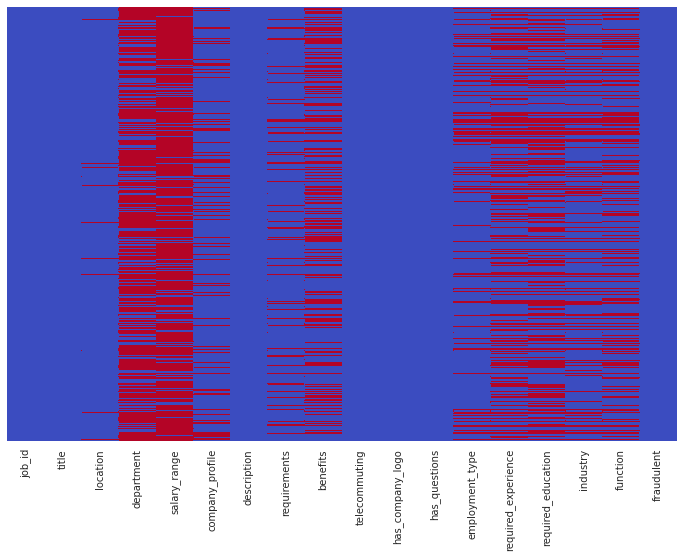

In [4]:
plt.figure(figsize=(12,8))
sns.heatmap(jobs.isnull(), cmap="coolwarm", yticklabels=False, cbar=False)

In [5]:
jobs.drop(columns=["department", "salary_range", "benefits"], inplace=True)

In [6]:
jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 15 columns):
job_id                 17880 non-null int64
title                  17880 non-null object
location               17534 non-null object
company_profile        14572 non-null object
description            17879 non-null object
requirements           15185 non-null object
telecommuting          17880 non-null int64
has_company_logo       17880 non-null int64
has_questions          17880 non-null int64
employment_type        14409 non-null object
required_experience    10830 non-null object
required_education     9775 non-null object
industry               12977 non-null object
function               11425 non-null object
fraudulent             17880 non-null int64
dtypes: int64(5), object(10)
memory usage: 2.0+ MB


In [7]:
jobs.describe()

,job_id,telecommuting,has_company_logo,has_questions,fraudulent
count,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000
mean,8940.500000,0.042897,0.795302,0.491723,0.048434
std,5161.655742,0.202631,0.403492,0.499945,0.214688
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,4470.750000,0.000000,1.000000,0.000000,0.000000
50%,8940.500000,0.000000,1.000000,0.000000,0.000000
75%,13410.250000,0.000000,1.000000,1.000000,0.000000
max,17880.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
jobs.isnull().sum()

job_id                    0
title                     0
location                346
company_profile        3308
description               1
requirements           2695
telecommuting             0
has_company_logo          0
has_questions             0
employment_type        3471
required_experience    7050
required_education     8105
industry               4903
function               6455
fraudulent                0
dtype: int64

In [9]:
# List with the columns to check the length of the text
feature_lst = ["company_profile", "description", "requirements"]

# For loop to treat the missing values in the columns of the feature_lst.
for col in feature_lst:
    # If the job post is real, change the missing values to "none"
    jobs.loc[(jobs[col].isnull()) & (jobs["fraudulent"] == 0), col] = "none"
    
    # If the job post is fake, change the missing values to "missing"
    jobs.loc[(jobs[col].isnull()) & (jobs["fraudulent"] == 1), col] = "missing"

In [10]:
# For loop to create new columns with the lengths of the ones in the feature_lst
for num,col in enumerate(feature_lst):
    jobs[str(num)] = jobs[col].apply(len)

In [11]:
# Rename the new columns created above
jobs = jobs.rename({"0": "profile_length", "1": "description_length", "2": "requirements_length"}, axis=1)

In [12]:
jobs.isnull().sum()

job_id                    0
title                     0
location                346
company_profile           0
description               0
requirements              0
telecommuting             0
has_company_logo          0
has_questions             0
employment_type        3471
required_experience    7050
required_education     8105
industry               4903
function               6455
fraudulent                0
profile_length            0
description_length        0
requirements_length       0
dtype: int64

In [13]:
jobs["fraudulent"].value_counts()

0    17014
1      866
Name: fraudulent, dtype: int64

# 2.1 Visualizations

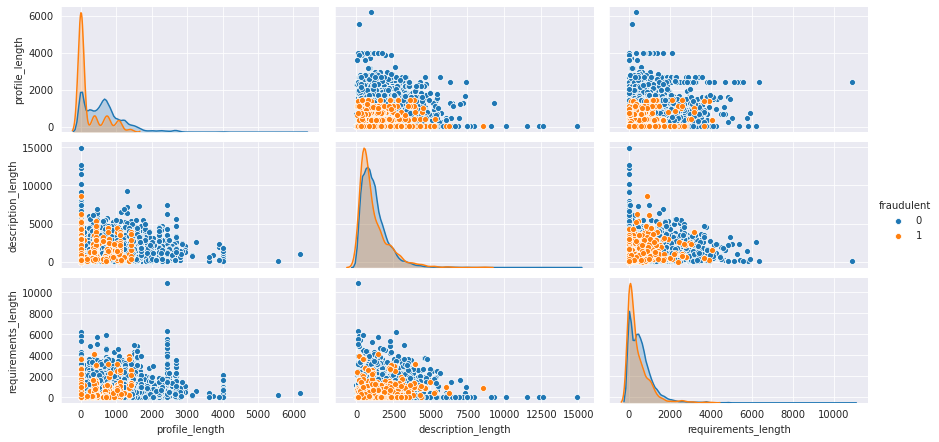

In [14]:
sns.pairplot(data=jobs[["fraudulent", "profile_length", "description_length", "requirements_length"]],
             hue="fraudulent", height=2, aspect=2);

 > **Apparently, the text length of the columns above does not show a different pattern for fraudulent or non-fraudulent posts. Let's take a closer look in each one individually.**

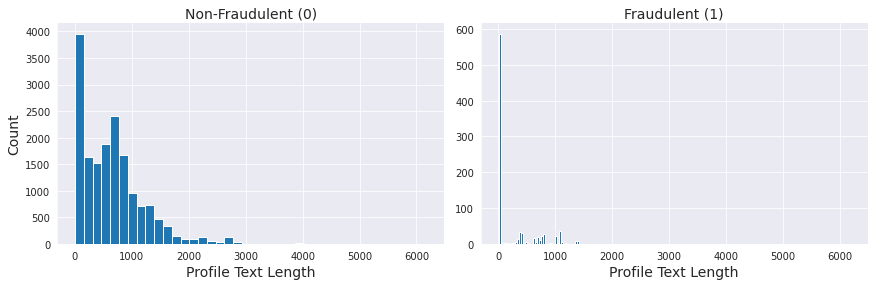

In [15]:
profile_grid = sns.FacetGrid(jobs, col="fraudulent", aspect=1.5, height=4, sharey=False)
profile_grid = profile_grid.map(plt.hist, "profile_length", bins=40)

# Flatten the axes. Create an iterator
axes = profile_grid.axes.flatten()

# Title
axes[0].set_title("Non-Fraudulent (0)", fontsize=14)
axes[1].set_title("Fraudulent (1)", fontsize=14)

# Labels
axes[0].set_ylabel("Count", fontsize=14)
for ax in axes:
    ax.set_xlabel("Profile Text Length", fontsize=14)

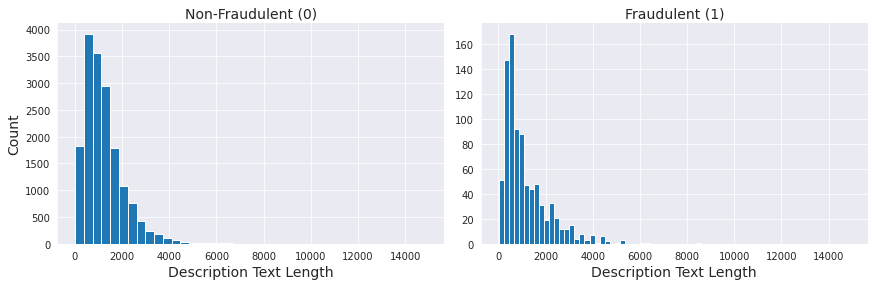

In [16]:
description_grid = sns.FacetGrid(jobs, col="fraudulent", aspect=1.5, height=4, sharey=False)
description_grid = description_grid.map(plt.hist, "description_length", bins=40)

# Flatten the axes. Create an iterator
axes = description_grid.axes.flatten()

# Title
axes[0].set_title("Non-Fraudulent (0)", fontsize=14)
axes[1].set_title("Fraudulent (1)", fontsize=14)

# Labels
axes[0].set_ylabel("Count", fontsize=14)
for ax in axes:
    ax.set_xlabel("Description Text Length", fontsize=14)

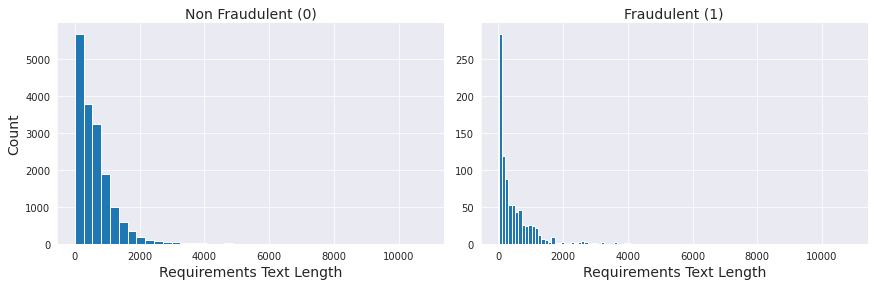

In [17]:
requirements_grid = sns.FacetGrid(jobs, col="fraudulent", aspect=1.5, height=4, sharey=False)
requirements_grid = requirements_grid.map(plt.hist, "requirements_length", bins=40)

# Another option. Makes less obviuos which axes is to be labelled
#requirements_grid.set_axis_labels("Requirement Length", "Count")

# Flatten the axes. Create an iterator
axes = requirements_grid.axes.flatten()

# Title
axes[0].set_title("Non Fraudulent (0)", fontsize=14)
axes[1].set_title("Fraudulent (1)", fontsize=14)

# Labels
axes[0].set_ylabel("Count", fontsize=14)
for ax in axes:
    ax.set_xlabel("Requirements Text Length", fontsize=14)

 > **The description and requirements columns present a very similar behaviour for the text length. That means that trying to use this features to predict if the job is fake or not probably would not work. In the case of the company_profile column, the two types of job post behave quite differently. The vast majority of the fraudulent job posts do not have a company profile available.**

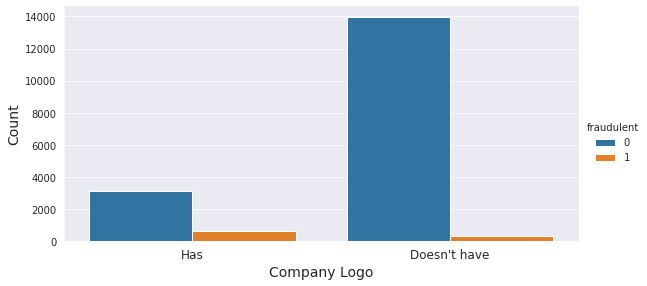

In [18]:
sns.catplot(x="has_company_logo", hue="fraudulent", data=jobs, kind="count", aspect=2, height=4);

plt.xlabel("Company Logo", fontsize=14)
plt.xticks([0, 1], ("Has", "Doesn't have"), fontsize=12)
plt.ylabel("Count", fontsize=14);

 > **The post being either real or fake, the majority of the job posts collected in this dataset do not have a company logo. This suggests that not having a logo is not a determining factor.**

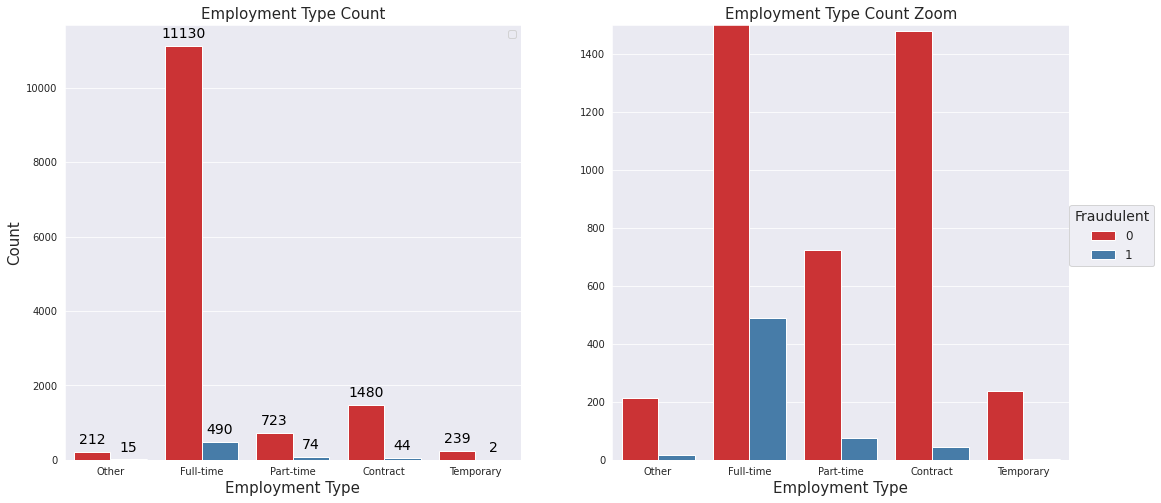

In [19]:
# Create a 1 by 2 figure and axes
fig, axes = plt.subplots(1, 2, figsize=(18,8))

# Plot a countplot on the first axes
employ = sns.countplot(x=jobs["employment_type"].dropna(), hue=jobs["fraudulent"], palette="Set1", ax=axes[0])
axes[0].set_xlabel("Employment Type", fontsize=15)
axes[0].set_ylabel("Count", fontsize=15)
axes[0].set_title("Employment Type Count", fontsize=15)
axes[0].legend("")

# Write the height of the bars on top
for p in employ.patches:
    employ.annotate("{:.0f}".format(p.get_height()), 
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', fontsize=14, color='black', xytext=(0, 12),
                        textcoords='offset points')

#############################################################

# Plot a countplot on the second axes
employ_zoom = sns.countplot(x=jobs["employment_type"].dropna(), hue=jobs["fraudulent"], palette="Set1", ax=axes[1])
axes[1].set_xlabel("Employment Type", fontsize=15)
axes[1].set_ylim((0, 1500))
axes[1].set_ylabel("")
axes[1].set_title("Employment Type Count Zoom", fontsize=15)
axes[1].legend(title="Fraudulent", title_fontsize=14, fontsize=12, bbox_to_anchor=(1.2, 0.6));

 > **The graph on the left shows the employment count for each employment type. The graph on the right shows the same information but it is zoomed in (see the difference in the y-axis values). Most of the jobs are full-time and in the first graph we can hardly see some fraudulent posts on the part-time type, not being able to see any fraudulent ads at all on the other employment types. When zoomed in we can see more fraudulent posts in all types. The fake percentage is:**
> - **Part-time: ~ 9%**
> - **Other: ~ 7%**
> - **Full-time: ~ 4%**
> - **Contract: ~ 3%**
> - **Temporary: ~ 1%**

# 3. Machine Learning Model

---
## 3.1 Train Test Split

In [20]:
jobs.columns

Index(['job_id', 'title', 'location', 'company_profile', 'description',
       'requirements', 'telecommuting', 'has_company_logo', 'has_questions',
       'employment_type', 'required_experience', 'required_education',
       'industry', 'function', 'fraudulent', 'profile_length',
       'description_length', 'requirements_length'],
      dtype='object')

In [21]:
X1_profile = jobs["company_profile"]
y1 = jobs["fraudulent"]
X1_profile_train, X1_profile_test, y1_train, y1_test = train_test_split(X1_profile, y1, test_size=0.2, random_state=42)

---
## 3.2 Pipelines

### I will try some different combinations of techniques to process the data and check which one returns a better result. For now I will only use the MultinomialNB.

In [22]:
def text_process(text):
    # Remove the punctuation
    nopunc = [char for char in text if char not in string.punctuation]
    
    # Join the list of characters to form strings
    nopunc = "".join(nopunc)
    
    # Remove stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words("english")]

## 3.2.1 - No analyser and no TFIDF

In [23]:
NB_pipeline = Pipeline([("bow no func", CountVectorizer()),
                       ("NB_classifier", MultinomialNB())])

In [24]:
NB_pipeline.fit(X1_profile_train, y1_train)

Pipeline(memory=None,
         steps=[('bow no func',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('NB_classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [25]:
NB_pred = NB_pipeline.predict(X1_profile_test)

In [26]:
print(classification_report(y1_test, NB_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      3395
           1       0.87      0.99      0.93       181

    accuracy                           0.99      3576
   macro avg       0.93      0.99      0.96      3576
weighted avg       0.99      0.99      0.99      3576



In [27]:
print(confusion_matrix(y1_test, NB_pred))

[[3368   27]
 [   2  179]]


***

## 3.2.2 - With analyser and no TFIDF

In [28]:
NB_func_pipeline = Pipeline([("bow with func", CountVectorizer(analyzer=text_process)),
                            ("NB_classifier", MultinomialNB())])

In [29]:
X2_profile = jobs["company_profile"]
y2 = jobs["fraudulent"]
X2_profile_train, X2_profile_test, y2_train, y2_test = train_test_split(X2_profile, y2, test_size=0.2, random_state=42)

In [30]:
NB_func_pipeline.fit(X2_profile_train, y2_train)

Pipeline(memory=None,
         steps=[('bow with func',
                 CountVectorizer(analyzer=<function text_process at 0x7f2f2c036b70>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('NB_classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [31]:
NB_func_pred = NB_func_pipeline.predict(X2_profile_test)

In [32]:
print(classification_report(y2_test, NB_func_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      3395
           1       0.86      0.99      0.92       181

    accuracy                           0.99      3576
   macro avg       0.93      0.99      0.96      3576
weighted avg       0.99      0.99      0.99      3576



In [33]:
print(confusion_matrix(y2_test, NB_func_pred))

[[3365   30]
 [   2  179]]


***

## 3.2.3 - No analyser and with TFIDF

In [34]:
NB_tfidf_pipeline = Pipeline([("bow no func", CountVectorizer()),
                              ("tfidf", TfidfTransformer()),
                              ("NB_classifier", MultinomialNB())])

In [35]:
X3_profile = jobs["company_profile"]
y3 = jobs["fraudulent"]
X3_profile_train, X3_profile_test, y3_train, y3_test = train_test_split(X3_profile, y3, test_size=0.2, random_state=42)

In [36]:
NB_tfidf_pipeline.fit(X3_profile_train, y3_train)

Pipeline(memory=None,
         steps=[('bow no func',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('NB_classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [37]:
NB_tfidf_pred = NB_tfidf_pipeline.predict(X3_profile_test)

In [38]:
print(classification_report(y3_test, NB_tfidf_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3395
           1       0.89      0.80      0.84       181

    accuracy                           0.98      3576
   macro avg       0.94      0.90      0.92      3576
weighted avg       0.98      0.98      0.98      3576



In [39]:
print(confusion_matrix(y3_test, NB_tfidf_pred))

[[3377   18]
 [  36  145]]


***

## 3.2.4 - With analyser and TFIDF

In [40]:
NB_func_tfidf_pipeline = Pipeline([("bow with func", CountVectorizer(analyzer=text_process)),
                              ("tfidf", TfidfTransformer()),
                              ("NB_classifier", MultinomialNB())])

In [41]:
X4_profile = jobs["company_profile"]
y4 = jobs["fraudulent"]
X4_profile_train, X4_profile_test, y4_train, y4_test = train_test_split(X4_profile, y4, test_size=0.2, random_state=42)

In [42]:
NB_func_tfidf_pipeline.fit(X4_profile_train, y4_train)

Pipeline(memory=None,
         steps=[('bow with func',
                 CountVectorizer(analyzer=<function text_process at 0x7f2f2c036b70>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('NB_classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=Fal

In [43]:
NB_func_tfidf_pred = NB_func_tfidf_pipeline.predict(X4_profile_test)

In [44]:
print(classification_report(y4_test, NB_func_tfidf_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3395
           1       0.92      0.89      0.90       181

    accuracy                           0.99      3576
   macro avg       0.96      0.94      0.95      3576
weighted avg       0.99      0.99      0.99      3576



In [45]:
print(confusion_matrix(y4_test, NB_func_tfidf_pred))

[[3381   14]
 [  20  161]]


 > **The best model was the one in which the text was processed and TFIDF was taken into account, presenting a 99% precision for real job posts and 92% precision for fake job posts. The text_process function basically removes any punctuation or stopwords. There are other things to try. Other classification models, e.g., logistic regression, K-Nearest Neighbors, etc can be tested. Overall, the MultinomialNB returned an excellent result.**